# Hi :)

----

# Import libraries

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from filterpy.monte_carlo import systematic_resample

# Loading the data

In [ ]:
# # Load data
# file_path= "pendulum_noisy_data.xlsx"
# df= pd.read_excel(file_path)

# # Extract true states and noisy measurements
# true_states= df[['x1', 'x2', 'x3', 'x4']].values
# measurements= df[['y1', 'y2']].values
# num_steps= len(measurements)

In [2]:
data= pd.read_excel('pendulum_noisy_data.xlsx')
y1= data['y1']
y2= data['y2']

# Initialization

In [ ]:
# # Physical parameters
# m= 0.1
# M= 5.0
# g= 9.81
# l= 0.72
# dt= 0.001

# # Dynamics model
# def pendulum_dynamics(x, u):
#     x1, x2, x3, x4= x
#     dx1= x2

#     num2= u * np.cos(x1) - (M + m) * g * np.sin(x1) + m * l * np.cos(x1) * np.sin(x1) * x2**2
#     den2= m * l * np.cos(x1)**2 - (M + m) * l
#     dx2= num2 / den2 if den2 != 0 else 0

#     dx3= x4

#     num4= u + m * l * np.sin(x1) * x2**2 - m * g * np.cos(x1) * np.sin(x1)
#     den4= M + m - m * np.cos(x1)**2
#     dx4= num4 / den4 if den4 != 0 else 0

#     return np.array([dx1, dx2, dx3, dx4])

# # Observation model: observe x1 and x3
# def observation_model(x):
#     return np.array([x[0], x[2]])

# # Systematic resampling
# def systematic_resample(particles, weights):
#     N= len(weights)
#     positions= (np.arange(N) + np.random.uniform()) / N
#     indexes= np.zeros(N, dtype= int)
#     cumulative_sum= np.cumsum(weights)
#     i, j= 0, 0
#     while i < N:
#         if positions[i] < cumulative_sum[j]:
#             indexes[i]= j
#             i += 1
#         else:
#             j += 1
#     return particles[indexes]

# # Parameters
# num_particles= 100
# state_dim= 4
# process_noise_std= np.array([0.01, 0.1, 0.01, 0.1])  # per state
# measurement_noise_std= 0.05  # assumes same std for x1 and x3

# # Initialization around first measurement
# initial_mean= [measurements[0, 0], 0, measurements[0, 1], 0]
# particles= np.random.normal(loc= initial_mean, scale= 0.2, size= (num_particles, state_dim))
# weights= np.ones(num_particles) / num_particles
# estimated_states= np.zeros((num_steps, state_dim))

In [3]:
N= 100
T= 0.01
m= 0.1
M= 5.0
g= 9.81
l= 0.72
Q= np.diag([15, 9.6, 10.0, 17.0])
R= np.diag([19.2, 16.8])

mean= np.array([-1.0, 1.0, -1.0, 1.0])  
cov= np.diag([0.5, 1.0, 0.5, 1.0])      

X0= np.random.multivariate_normal(mean= mean, cov= cov,size= N)

def fx(x, dt):
    x1= x[0]
    x2= x[1]
    x3= x[2]
    x4= x[3]
    u= 0
    wk= np.random.multivariate_normal(mean= np.zeros(4), cov= Q)
    dx1= x2
    dx2= (u * np.cos(x1) - (M + m) * g * np.sin(x1) + m * l * np.cos(x1) * np.sin(x1) * x2**2) / (m * l * np.cos(x1)**2 - (M + m) * l)
    dx3= x4
    dx4= (u + m * l * np.sin(x1) * x2**2 - m * g * np.cos(x1) * np.sin(x1)) / (M + m - m * np.cos(x1)**2)

    return np.array([x1 + dx1 * dt, x2 + dx2 * dt, x3 + dx3 * dt, x4 + dx4 * dt]) + wk

def SIRPF(x_posterior, y):

    H= np.array([[1,0,0,0],
                 [0,0,1,0]])
    X_prior= []
    weight= []
    
    # 2a - Use incoming particles, not X0
    for i in x_posterior:
        x= fx(i, T)
        X_prior.append(x)
    
    # 2b - Compute weights
    for j in range(len(x_posterior)):
        residual= y - H @ X_prior[j]
        w= np.exp(-0.5 * residual.T @ np.linalg.inv(R) @ residual)
        weight.append(w)

    # 2c - Normalize weights
    weight= np.array(weight)
    weight_sum= np.sum(weight)
    weight /= weight_sum

    # 2d - Resample
    X_prior= np.array(X_prior)
    indexes= systematic_resample(weight)
    resample_particle= X_prior[indexes]

    # 2e - Estimate state
    x_hat= np.mean(resample_particle, axis= 0)
    return x_hat, resample_particle

# PF

In [ ]:
# # Main loop
# for t in range(num_steps):
#     u= 0  # no control input

#     # Predict step
#     for i in range(num_particles):
#         dx= pendulum_dynamics(particles[i], u)
#         process_noise= np.random.normal(0, process_noise_std)
#         particles[i] += dx * dt + process_noise

#     # Update weights
#     z= measurements[t]
#     for i in range(num_particles):
#         predicted_z= observation_model(particles[i])
#         error= z - predicted_z
#         weights[i]= np.exp(-0.5 * np.sum((error / measurement_noise_std)**2))

#     weights += 1.e-300
#     weights /= np.sum(weights)

#     # Estimate state
#     estimated_states[t]= np.average(particles, weights= weights, axis= 0)

#     # Resample if needed
#     effective_N= 1. / np.sum(weights**2)
#     if effective_N < num_particles / 2:
#         particles= systematic_resample(particles, weights)
#         weights.fill(1.0 / num_particles)

In [4]:
z= np.array([y1[0], y2[0]])
x_estimate= []

new_x, new_particle= SIRPF(X0, z)
x_estimate.append(new_x)

for i in range(1, len(y1)):
    z= np.array([y1[i], y2[i]])
    new_x, new_particle= SIRPF(new_particle, z)
    x_estimate.append(new_x)

# RMSE

In [37]:
# # Compute RMSE for each state variable
# rmse= np.sqrt(np.mean((estimated_states - true_states)**2, axis= 0))

# # Display RMSE for each state
# for i in range(4):
#     print(f"RMSE for x{i + 1}: {rmse[i]:.4f}")

In [40]:
# Compute RMSE for each state variable
x_estimate= pd.DataFrame(x_estimate).values
true_values= data[['x1', 'x2', 'x3', 'x4']].values
rmse= np.sqrt(np.mean((x_estimate - true_values)**2, axis= 0))

# Display RMSE for each state
for i in range(4):
    print(f"RMSE for x{i + 1}: {rmse[i]:.4f}")

RMSE for x1: 3.4138
RMSE for x2: 264.3648
RMSE for x3: 3.1114
RMSE for x4: 377.5646


# Visualization

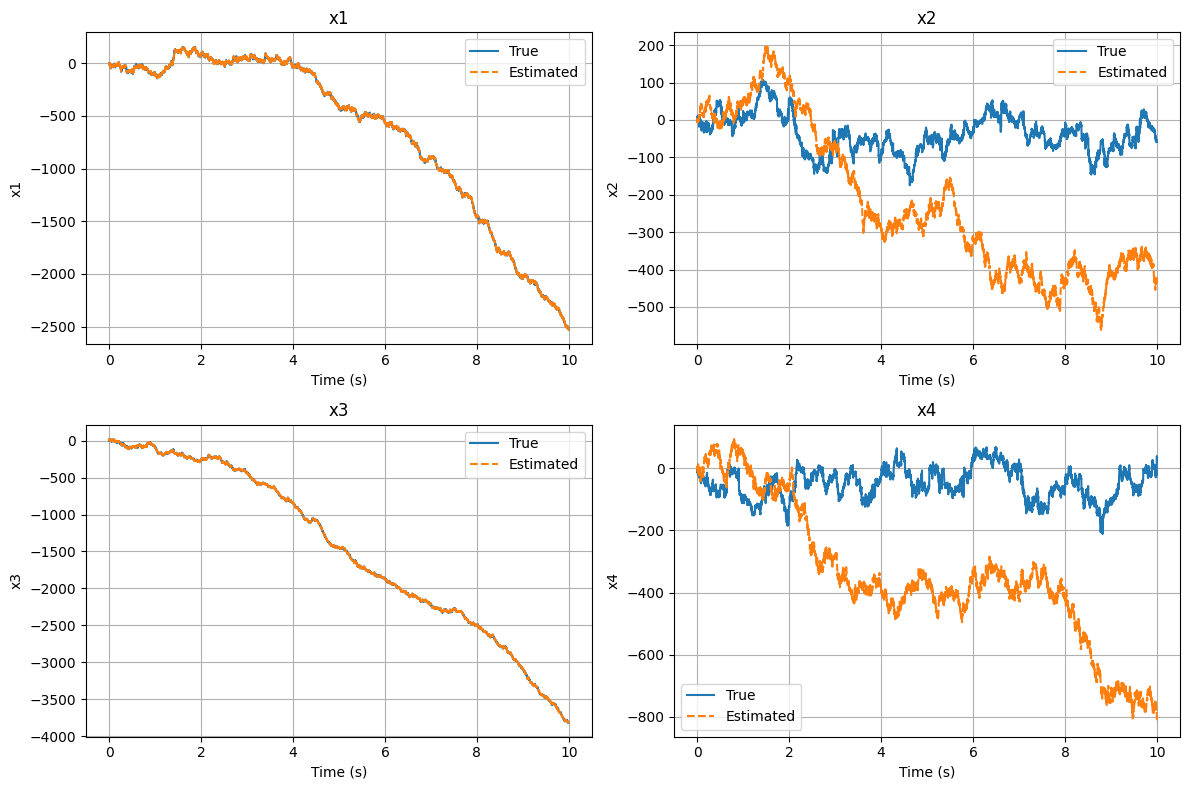

In [42]:
# Plot estimated vs true states
time= np.arange(10001) * 0.001
labels= ['x1', 'x2', 'x3', 'x4']

plt.figure(figsize= (12, 8))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(time, x_estimate[:, i], label= 'True')
    plt.plot(time, true_values[:, i], label= 'Estimated', linestyle= '--')
    plt.title(labels[i])
    plt.xlabel('Time (s)')
    plt.ylabel(labels[i])
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()